# Stage 1: Solve Segmentation problem

[Dataset](https://drive.google.com/drive/folders/196tuNaIivzsfsKOdrNy9tMrENJpMeFBW): 6D pose estimation
- [Additional test data](https://drive.google.com/drive/folders/196tuNaIivzsfsKOdrNy9tMrENJpMeFBW)

## Tips

- Advanced Pipeline ([paper](https://arxiv.org/abs/1911.04231))

## Dataset

- `./training_data`: Training data with pose
- `./testing_data`: Testing data with segmentation mast
- `./testing_data_final`: Testing data without segmentation mast

## 1. Preview Training Data for UNet Segmentation Task

There are [23] objects in total
---- Initializing Dataset ---- 
	 Length: 236
	 Sample points per scene: 921600
	 Split: val
	 Train: True
	 transforms: None
[['35' 'jenga']
 ['39' 'master_chef_can']
 ['48' 'potted_meat_can']
 ['51' 'pudding_box']
 ['58' 'wood_block']] Scene: 1-1-4


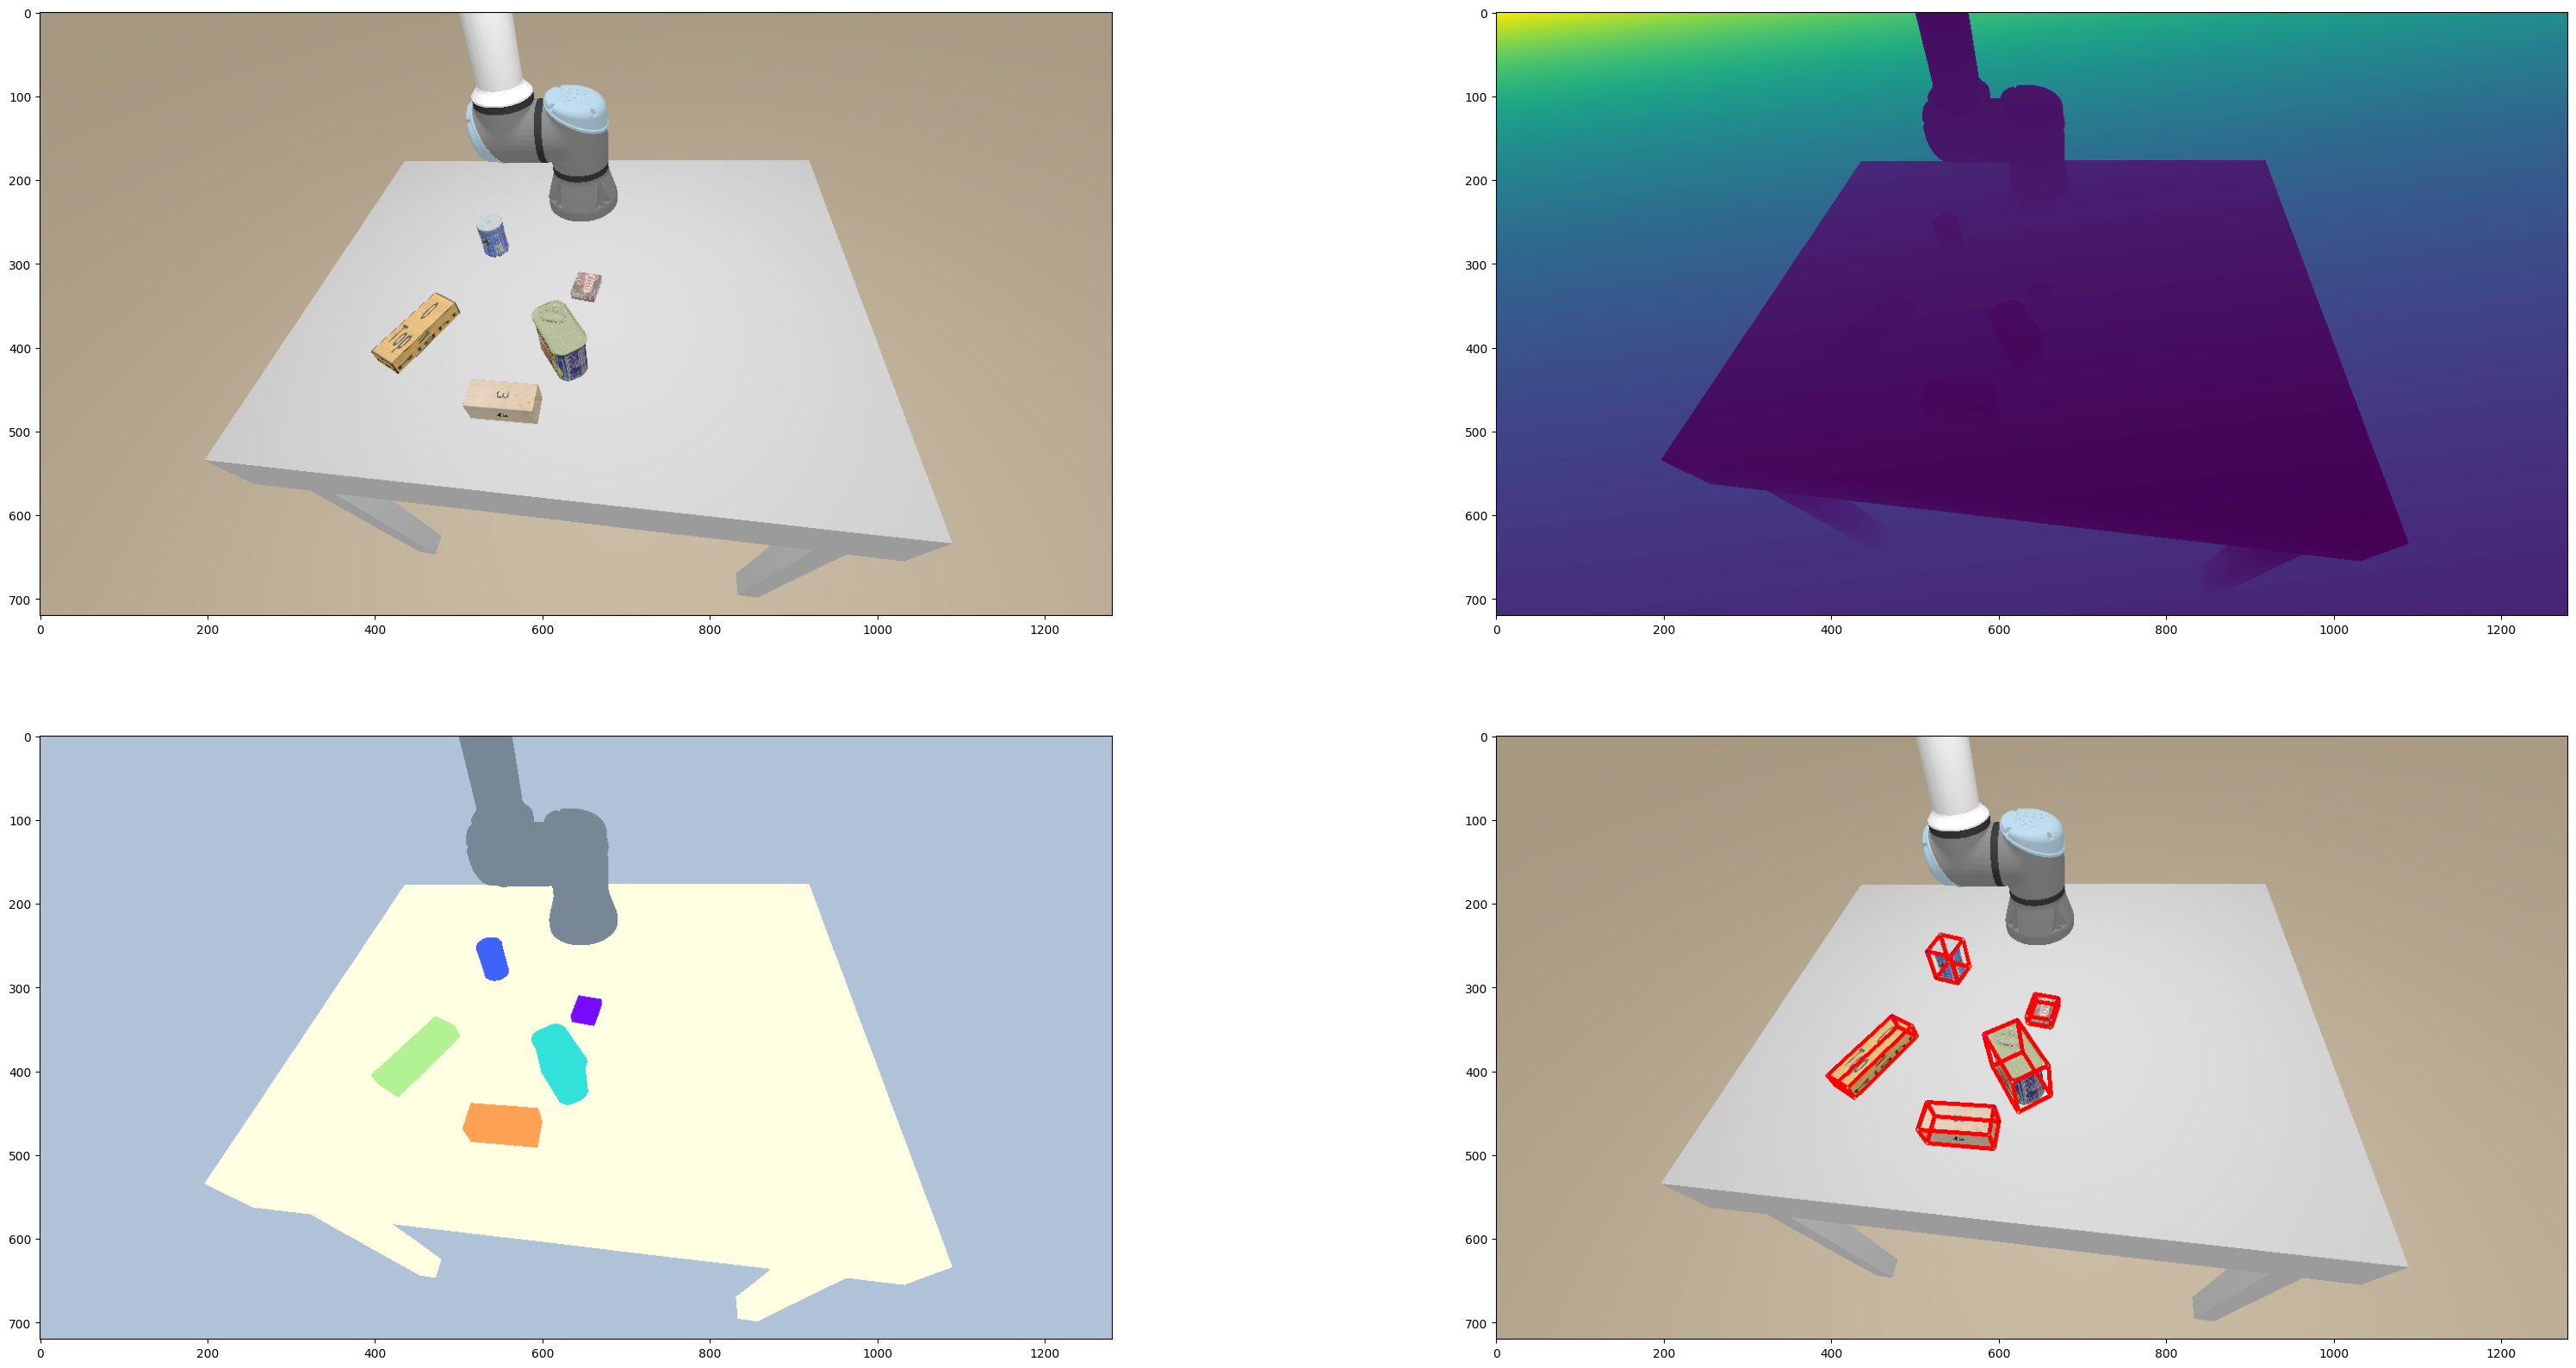

In [3]:
from utils.utils_data import *


params = {'bz': 1, 'shuffle': False, 'num_workers':1}


seg_dataset = SegDataset(split_name='val', transforms=None)
loader = get_loader(seg_dataset, params)


''' Sample 1 batch from dataset, and visualize '''
sample = next(iter(loader))
rgb    = sample['rgb']        # (B,3,H,W)
label  = sample['label']      # (B,1,H,W)
depth  = sample['depth']      # (B,1,H,W)
# kpof_gt = sample['kpof_gt']   # (B, N_pts, N_kps, 3)
# ctof_gt = sample['ctof_gt']   # (B, N_pts, 3)
# pcd_rgb = sample['pcd_rgb']   # (B, N_pts, 6)
meta   = sample['meta']       # List (B,)
meta = load_pickle(meta[0])
suffix = sample['suffix']     # List (B,)
suffix = suffix[0]


depth = depth.squeeze(0).permute(1,2,0).detach().numpy()
rgb   = rgb.squeeze(0).permute(1,2,0).detach().numpy()
label = label.squeeze().detach().numpy()
visualize_one_scene(rgb, depth, label, meta, suffix)

## 2. Train UNet

In [2]:
from utils.utils_data import *
from utils.unet import *
from torchvision.transforms import *
from datetime import datetime
import logging

''' ---- Starter Information ---- '''

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
split_name = 'val_tiny'
checkpoint = None

params = {
    "device":device,                    
    'bz': 1, 'shuffle': True, 'num_workers':2,    # 1. For loader
    "epochs": 50, "lr": 1e-3,                    # 2. For learning
    "scale":0.5,    "amp": False,                 # 3. Grad scaling
    "checkpoint": None
}

transforms = {
    # 'rgb'  : Compose([RandomHorizontalFlip()]),
    # 'depth': Compose([Resize((360, 640))]),
    # 'label': Compose([RandomHorizontalFlip()]),
}

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logging.info(f'Using device {device}')


net = UNet(n_channels=3, n_classes=82, bilinear=True).to(device=device)
loader = get_loader(SegDataset(split_name=split_name, transforms=transforms, one_hot_label=True), params=params)

if checkpoint:
    print(f'Resuming from checkpoint {checkpoint}')
    net.load_state_dict(torch.load(checkpoint))
logging.info(f'Network:\n'
                f'\t{net.n_channels} input channels\n'
                f'\t{net.n_classes} output channels (classes)\n'
                f'\t{"Bilinear" if net.bilinear else "Transposed conv"} upscaling')


now = datetime.now().strftime("%d-%H:%M")
epochs = params['epochs']

try:        
    train_net(net, loader, params, checkpoint=False)
    fname = f'./exp/unet/unet_weight_epochs{epochs}_{now}.pt'
    torch.save(net.state_dict(), fname)
except KeyboardInterrupt:
    fname = f'./exp/unet/unet_weight_INTERRUPTED_{now}_.pt'
    torch.save(net.state_dict(), fname)
    print(f'Checkpoint saved to: {fname}')

INFO: Using device cuda
INFO: Network:
	3 input channels
	82 output channels (classes)
	Bilinear upscaling
INFO: Starting training:
        Epochs:          50
        Learning rate:   0.001
        Training size (num batches):   14
        Batch size:      1
        Checkpoints:     None
        Device:          cuda
        Images scaling:  0.5
        Mixed Precision: False
    


There are [23] objects in total
---- Initializing Dataset ---- 
	 Length: 14
	 Sample points per scene: 921600
	 Split: val_tiny
	 Train: True
	 transforms: {}


Epoch 1/50: 100%|██████████| 14/14 [00:06<00:00,  2.26img/s, loss (batch)=0.279]


35.27713871002197


Epoch 2/50: 100%|██████████| 14/14 [00:06<00:00,  2.25img/s, loss (batch)=0.18] 


3.399123415350914


Epoch 3/50: 100%|██████████| 14/14 [00:06<00:00,  2.23img/s, loss (batch)=0.166]


2.3471853137016296


Epoch 4/50: 100%|██████████| 14/14 [00:06<00:00,  2.25img/s, loss (batch)=0.116]


1.7842917516827583


Epoch 5/50: 100%|██████████| 14/14 [00:06<00:00,  2.25img/s, loss (batch)=0.0869]


1.365863598883152


Epoch 6/50: 100%|██████████| 14/14 [00:06<00:00,  2.23img/s, loss (batch)=0.0765]


1.109584890305996


Epoch 7/50: 100%|██████████| 14/14 [00:06<00:00,  2.23img/s, loss (batch)=0.0498]


0.861991573125124


Epoch 8/50: 100%|██████████| 14/14 [00:06<00:00,  2.23img/s, loss (batch)=0.0449]


0.6811065971851349


Epoch 9/50: 100%|██████████| 14/14 [00:06<00:00,  2.22img/s, loss (batch)=0.0338]


0.5721848495304585


Epoch 10/50: 100%|██████████| 14/14 [00:06<00:00,  2.21img/s, loss (batch)=0.0271]


0.4792088493704796


Epoch 11/50: 100%|██████████| 14/14 [00:06<00:00,  2.22img/s, loss (batch)=0.0252]


0.39880003593862057


Epoch 12/50: 100%|██████████| 14/14 [00:06<00:00,  2.21img/s, loss (batch)=0.0243]


0.3455226868391037


Epoch 13/50: 100%|██████████| 14/14 [00:06<00:00,  2.23img/s, loss (batch)=0.0273]


0.3472316423431039


Epoch 14/50: 100%|██████████| 14/14 [00:06<00:00,  2.23img/s, loss (batch)=0.0321]


0.2791173355653882


Epoch 15/50: 100%|██████████| 14/14 [00:06<00:00,  2.23img/s, loss (batch)=0.0207]


0.2452981099486351


Epoch 16/50: 100%|██████████| 14/14 [00:06<00:00,  2.24img/s, loss (batch)=0.0131]


0.28340976126492023


Epoch 17/50: 100%|██████████| 14/14 [00:06<00:00,  2.24img/s, loss (batch)=0.0183]


0.24316390976309776


Epoch 18/50: 100%|██████████| 14/14 [00:06<00:00,  2.23img/s, loss (batch)=0.0126]


0.23075050860643387


Epoch 19/50: 100%|██████████| 14/14 [00:06<00:00,  2.24img/s, loss (batch)=0.0119] 


0.18507304042577744


Epoch 20/50: 100%|██████████| 14/14 [00:06<00:00,  2.23img/s, loss (batch)=0.00867]


0.16078965459018946


Epoch 21/50: 100%|██████████| 14/14 [00:06<00:00,  2.21img/s, loss (batch)=0.0105] 


0.12825526297092438


Epoch 22/50: 100%|██████████| 14/14 [00:06<00:00,  2.22img/s, loss (batch)=0.00665]


0.12014388618990779


Epoch 23/50: 100%|██████████| 14/14 [00:06<00:00,  2.22img/s, loss (batch)=0.00835]


0.14299574587494135


Epoch 24/50: 100%|██████████| 14/14 [00:06<00:00,  2.23img/s, loss (batch)=0.00983]


0.12323916424065828


Epoch 25/50: 100%|██████████| 14/14 [00:06<00:00,  2.23img/s, loss (batch)=0.00859]


0.1380200693383813


Epoch 26/50: 100%|██████████| 14/14 [00:06<00:00,  2.24img/s, loss (batch)=0.0927]


0.9848850471898913


Epoch 27/50: 100%|██████████| 14/14 [00:06<00:00,  2.23img/s, loss (batch)=0.0796]


0.9557639993727207


Epoch 28/50: 100%|██████████| 14/14 [00:06<00:00,  2.24img/s, loss (batch)=0.027] 


0.5491222180426121


Epoch 29/50: 100%|██████████| 14/14 [00:06<00:00,  2.22img/s, loss (batch)=0.0202]


0.37731638364493847


Epoch 30/50: 100%|██████████| 14/14 [00:06<00:00,  2.24img/s, loss (batch)=0.0268]


0.2890703473240137


Epoch 31/50: 100%|██████████| 14/14 [00:06<00:00,  2.24img/s, loss (batch)=0.0154]


0.24031195044517517


Epoch 32/50: 100%|██████████| 14/14 [00:06<00:00,  2.23img/s, loss (batch)=0.00977]


0.19373750127851963


Epoch 33/50: 100%|██████████| 14/14 [00:06<00:00,  2.24img/s, loss (batch)=0.00934]


0.1436887551099062


Epoch 34/50: 100%|██████████| 14/14 [00:06<00:00,  2.24img/s, loss (batch)=0.00965]


0.12243000324815512


Epoch 35/50: 100%|██████████| 14/14 [00:06<00:00,  2.24img/s, loss (batch)=0.0138] 


0.12611465901136398


Epoch 36/50: 100%|██████████| 14/14 [00:06<00:00,  2.21img/s, loss (batch)=0.0083] 


0.14120707660913467


Epoch 37/50: 100%|██████████| 14/14 [00:06<00:00,  2.22img/s, loss (batch)=0.00914]


0.11113142454996705


Epoch 38/50: 100%|██████████| 14/14 [00:06<00:00,  2.25img/s, loss (batch)=0.0121] 


0.10456269653514028


Epoch 39/50: 100%|██████████| 14/14 [00:06<00:00,  2.23img/s, loss (batch)=0.00542]


0.10152981337159872


Epoch 40/50: 100%|██████████| 14/14 [00:06<00:00,  2.23img/s, loss (batch)=0.0129]


0.16999806370586157


Epoch 41/50: 100%|██████████| 14/14 [00:06<00:00,  2.22img/s, loss (batch)=0.0167] 


0.11791916145011783


Epoch 42/50: 100%|██████████| 14/14 [00:06<00:00,  2.21img/s, loss (batch)=0.00519]


0.1360804890282452


Epoch 43/50: 100%|██████████| 14/14 [00:06<00:00,  2.24img/s, loss (batch)=0.00467]


0.08545175334438682


Epoch 44/50: 100%|██████████| 14/14 [00:06<00:00,  2.21img/s, loss (batch)=0.00341]


0.06479956256225705


Epoch 45/50: 100%|██████████| 14/14 [00:06<00:00,  2.22img/s, loss (batch)=0.01]   


0.08637058758176863


Epoch 46/50: 100%|██████████| 14/14 [00:06<00:00,  2.22img/s, loss (batch)=0.00385]


0.07961742975749075


Epoch 47/50: 100%|██████████| 14/14 [00:06<00:00,  2.24img/s, loss (batch)=0.00281]


0.050439471611753106


Epoch 48/50: 100%|██████████| 14/14 [00:06<00:00,  2.25img/s, loss (batch)=0.00203]


0.03980919369496405


Epoch 49/50: 100%|██████████| 14/14 [00:06<00:00,  2.24img/s, loss (batch)=0.0018] 


0.03482774691656232


Epoch 50/50: 100%|██████████| 14/14 [00:06<00:00,  2.23img/s, loss (batch)=0.00311]


0.030263246968388557


### Show output of 1 validation sample

There are [23] objects in total
---- Initializing Dataset ---- 
	 Length: 14
	 Sample points per scene: 921600
	 Split: val_tiny
	 Train: True
	 transforms: None
Shapes: rgb torch.Size([1, 3, 720, 1280]), depth torch.Size([1, 1, 720, 1280]), label torch.Size([1, 1, 720, 1280])
Shapes: rgb (torch.Size([1, 3, 720, 1280]), torch.float32), depth torch.Size([1, 1, 720, 1280]), label torch.Size([1, 1, 720, 1280])
pred shape: torch.Size([720, 1280])
rgb shape: torch.Size([1, 3, 720, 1280])
in visualize: label torch.Size([720, 1280])
[['35' 'jenga']
 ['39' 'master_chef_can']
 ['48' 'potted_meat_can']
 ['51' 'pudding_box']
 ['58' 'wood_block']] Scene: ['1-1-4']
in visualize: label torch.Size([720, 1280])
[['35' 'jenga']
 ['39' 'master_chef_can']
 ['48' 'potted_meat_can']
 ['51' 'pudding_box']
 ['58' 'wood_block']] Scene: ['1-1-4']


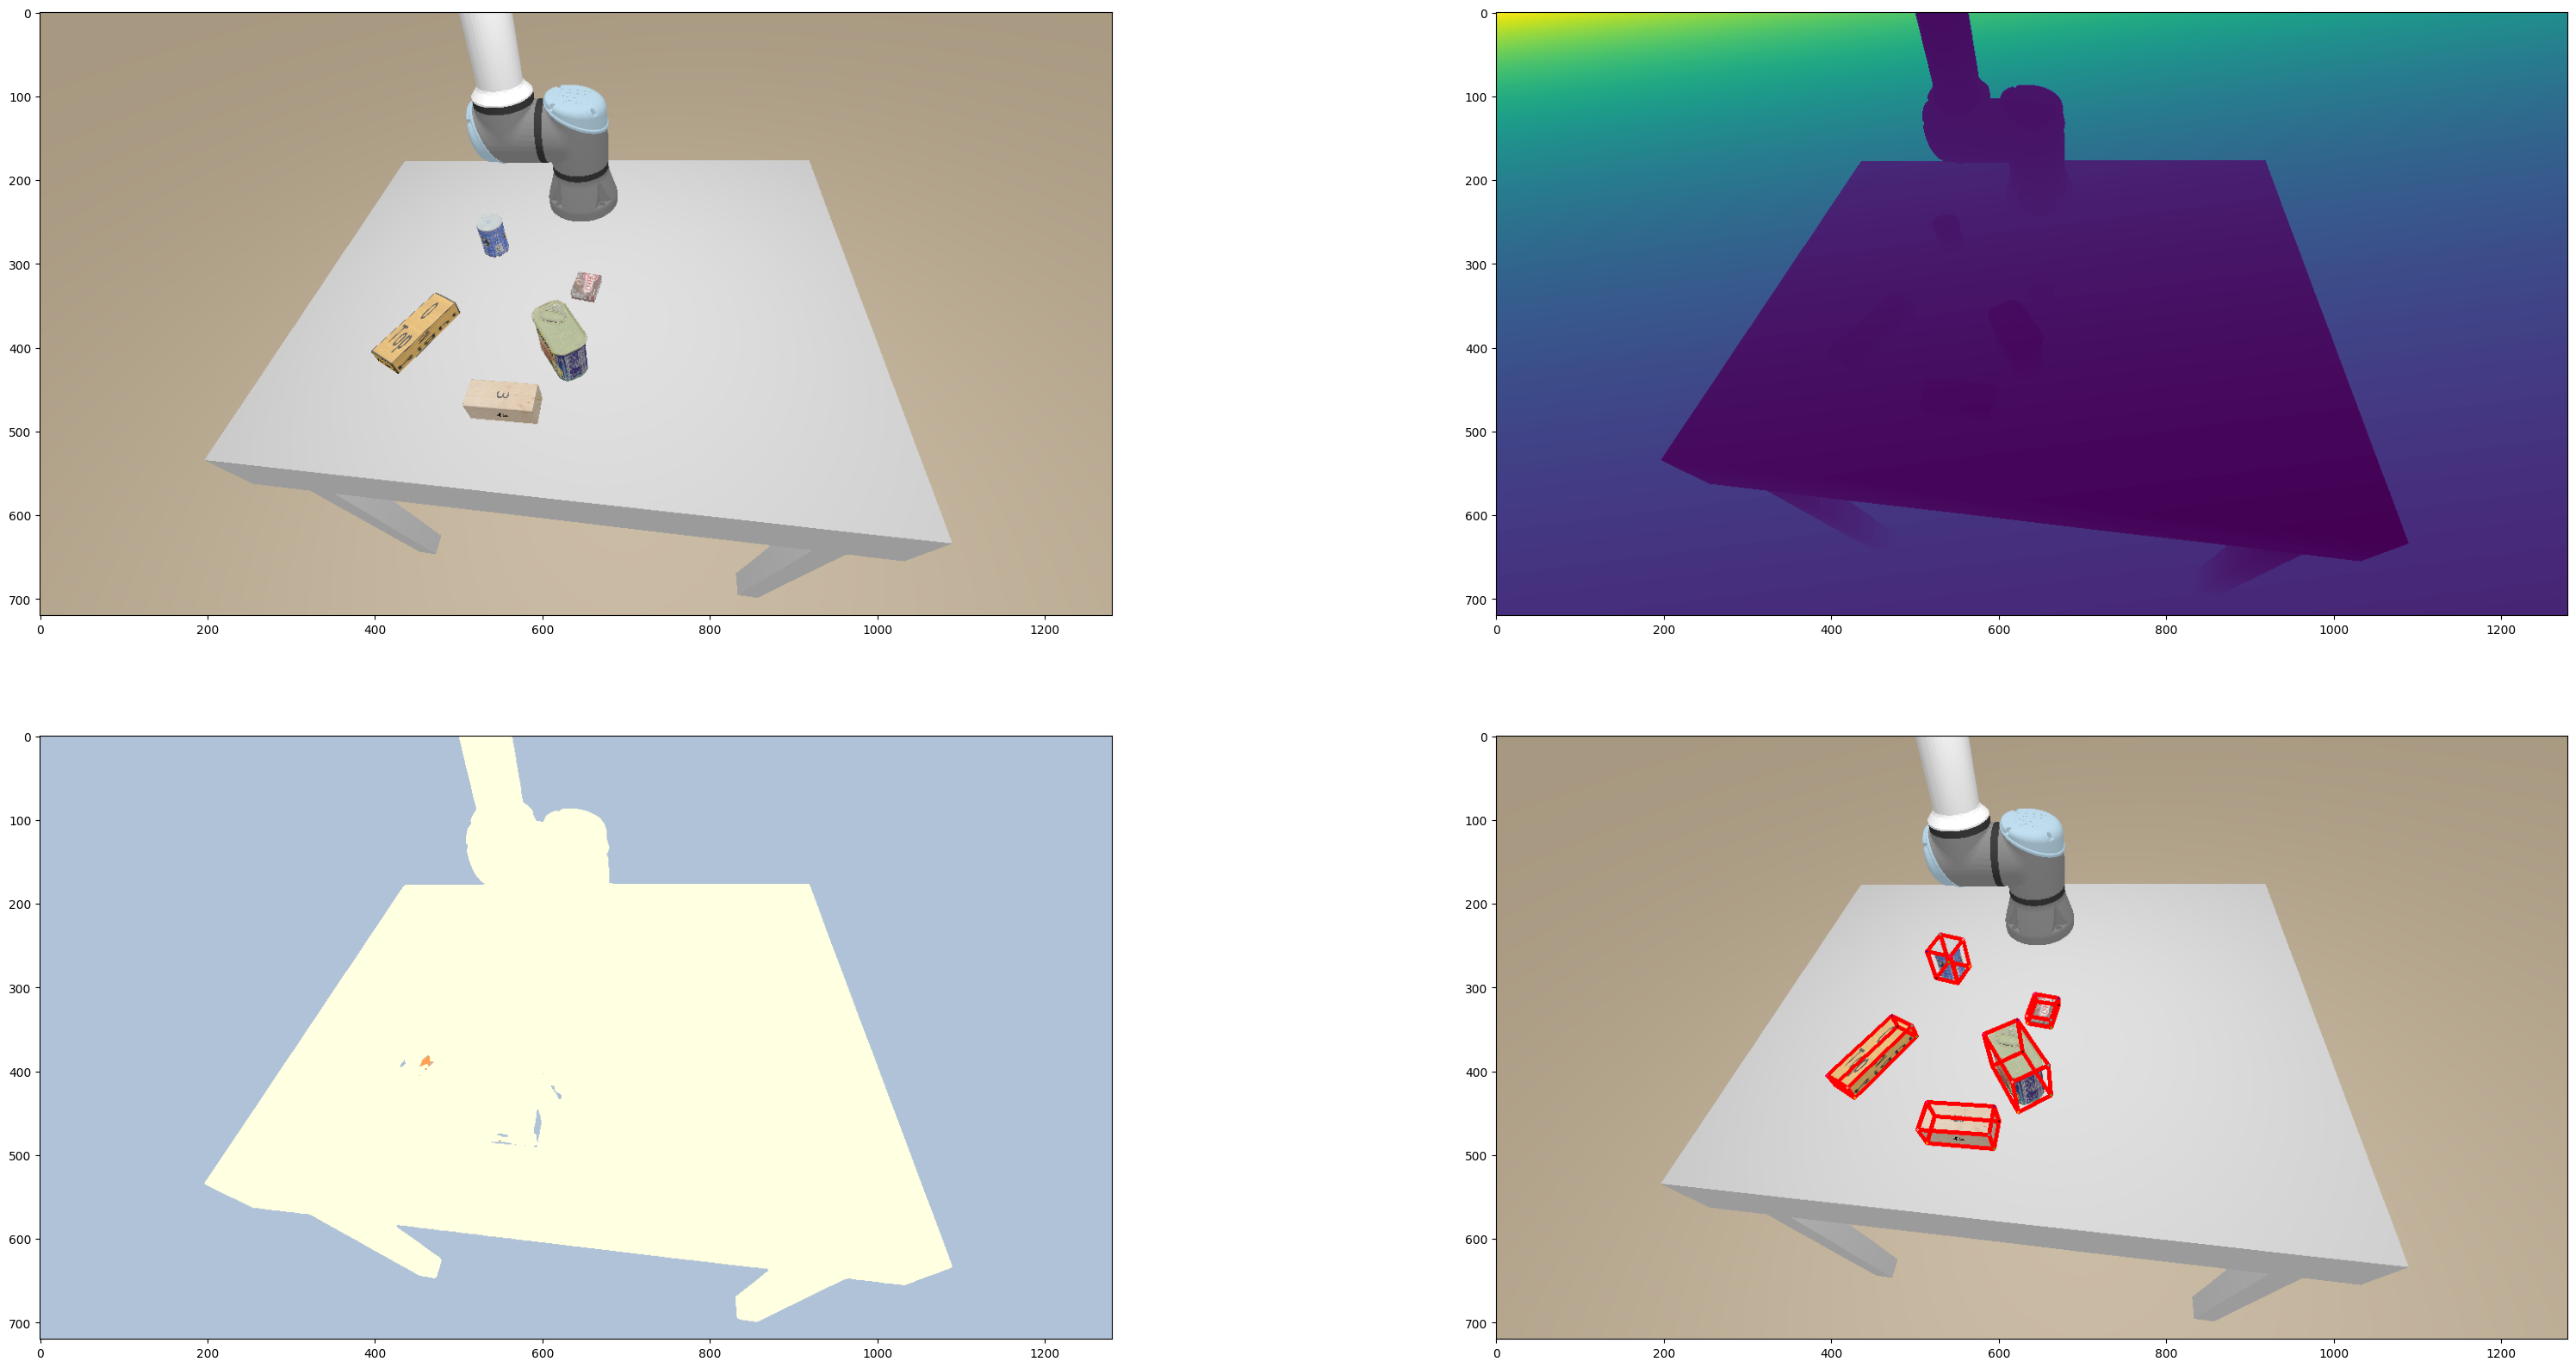

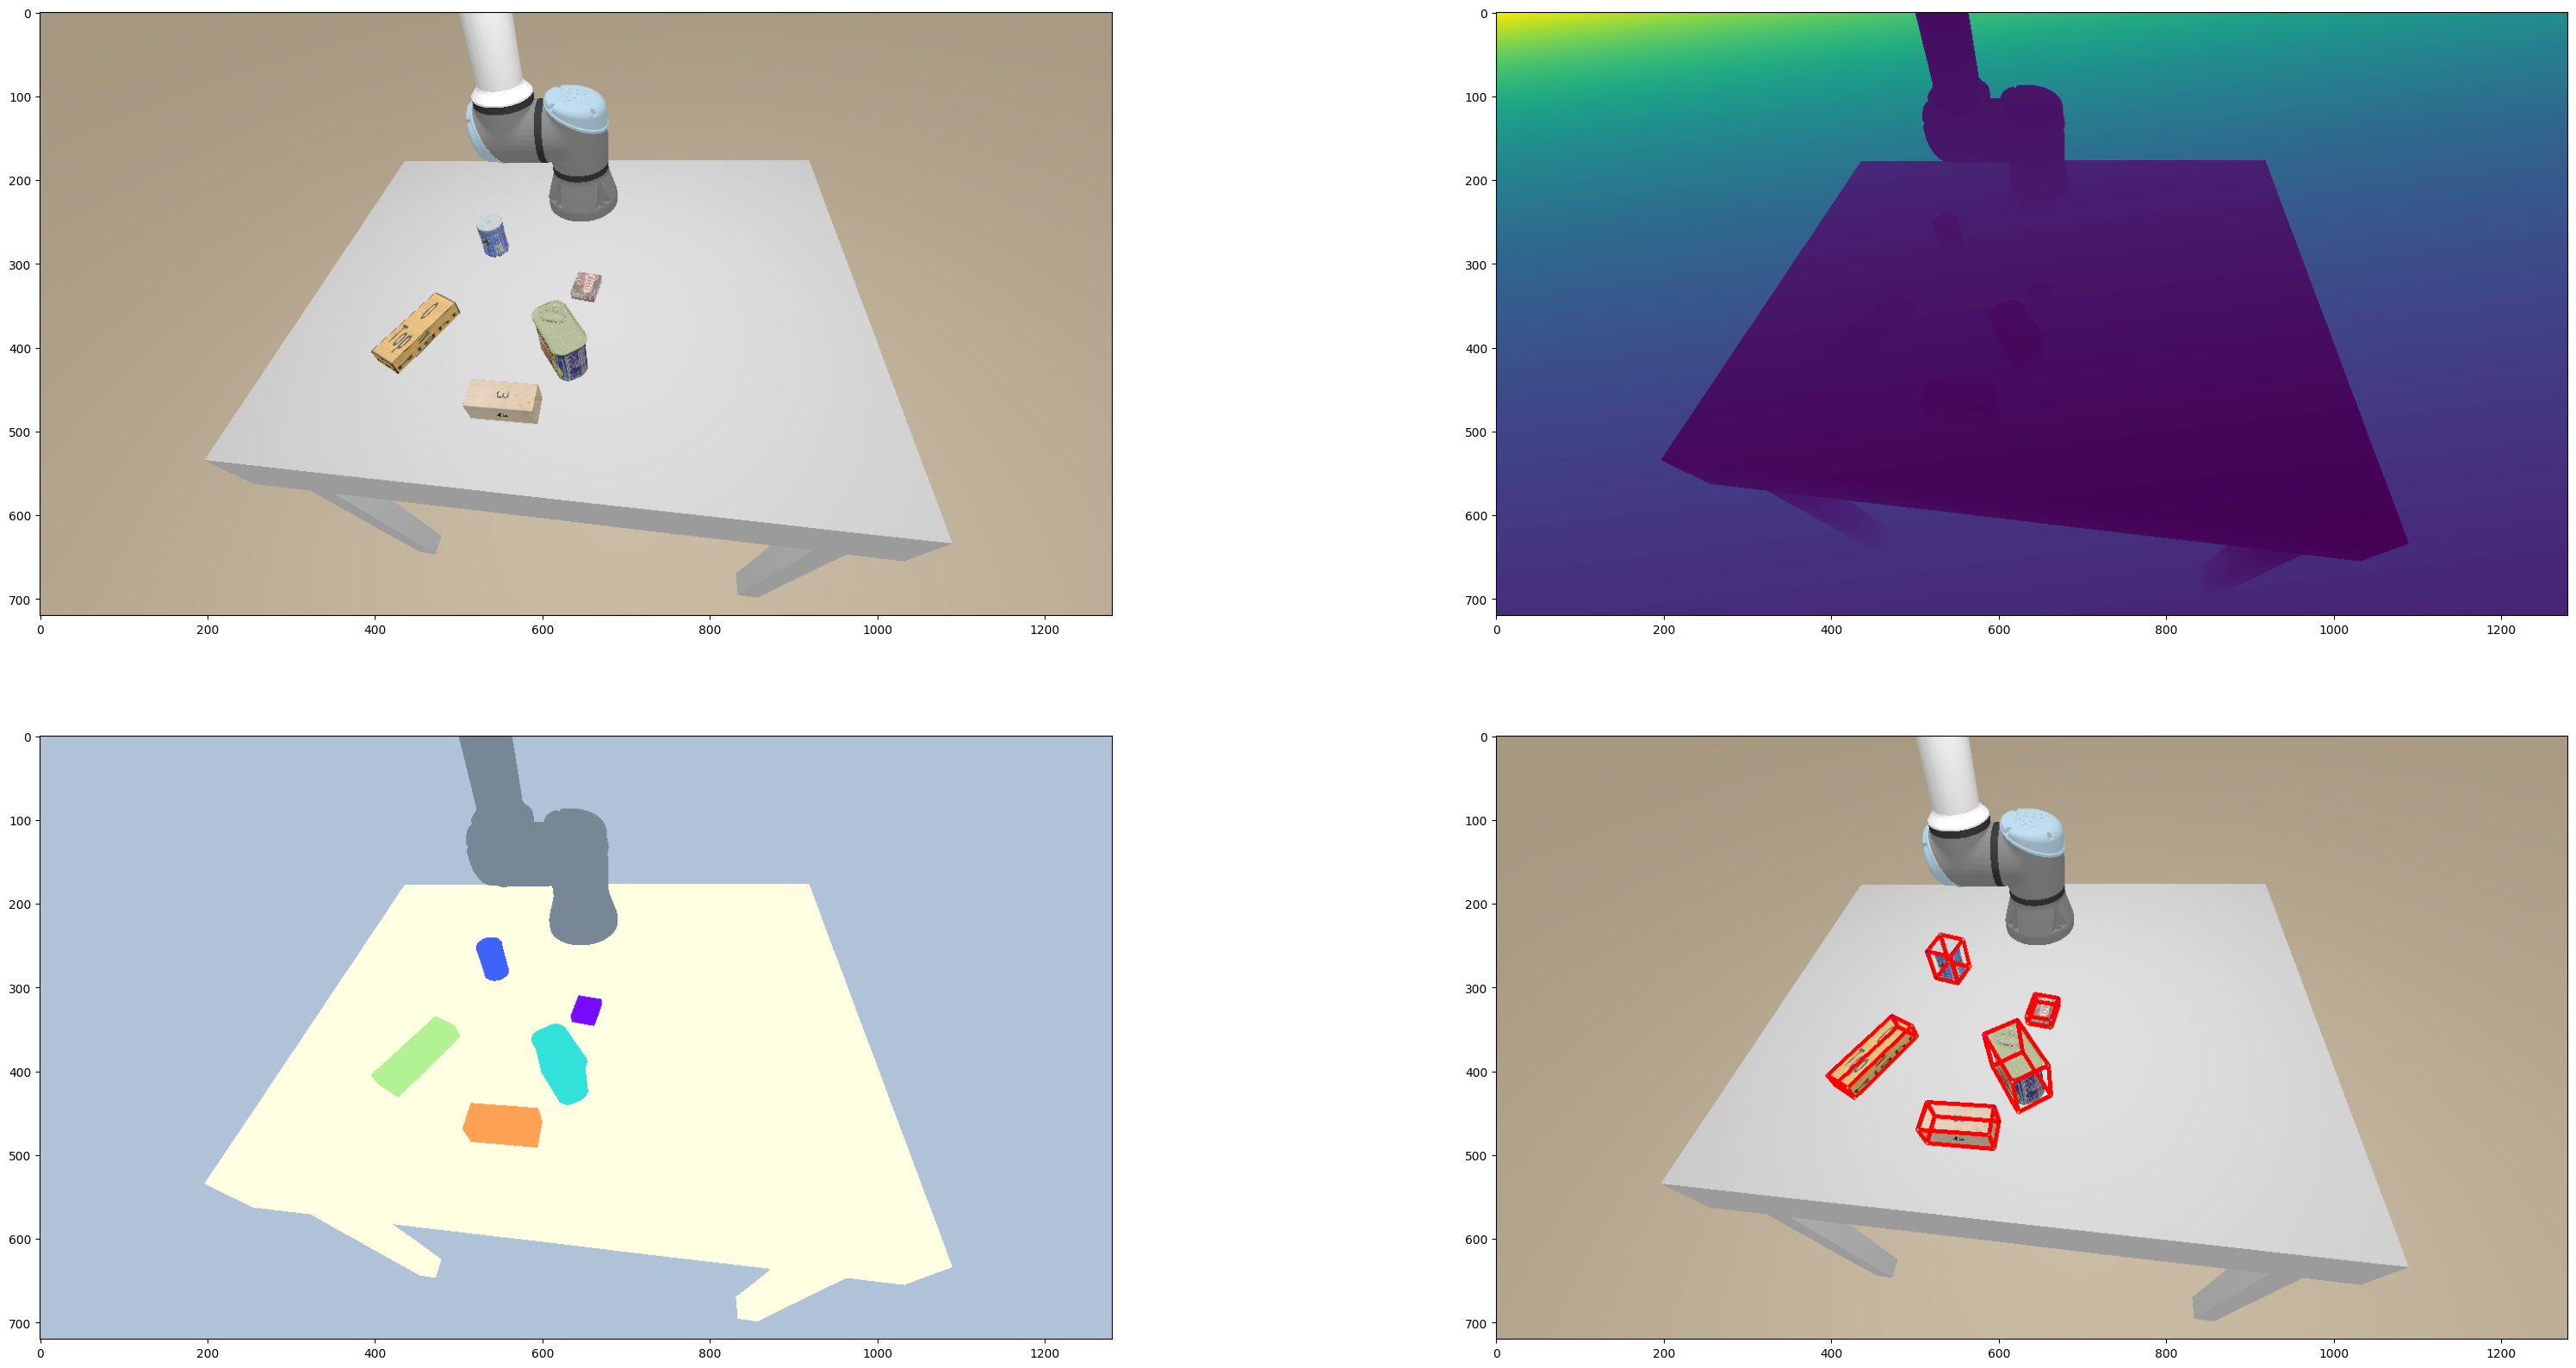

In [4]:
from utils.utils_data import *
from utils.unet import *
from torchvision.transforms import *
import torch.nn.functional as F


# checkpoint = 'exp/unet_weight_epoch1_train_ok.pt'   # TODO: Modify me for each trial
checkpoint = fname
device = torch.device('cpu')
params = {'bz': 1, 'shuffle': False, 'num_workers':1}
loader_val = get_loader(SegDataset(split_name='val_tiny', transforms=None), params=params) # TODO: Modify me for each trial

''' Get one sample from loader '''
sample = next(iter(loader_val))
rgb, depth, label, meta, suffix = \
        sample['rgb'], sample['depth'], sample['label'], sample['meta'], sample['suffix']
meta = load_pickle(meta[0])


print(f"Shapes: rgb {rgb.shape}, depth {depth.shape}, label {label.shape}")

'''Init net, load weight '''
net = UNet(n_channels=3, n_classes=82, bilinear=True).to(device)
net.load_state_dict(torch.load(checkpoint))
net.eval()

eval_one_scene(net, sample)

## 3. Save self-segmented images

In [2]:
from utils.utils_data import *
from utils.unet import *
from torchvision.transforms import *
import torch.nn.functional as F


device = torch.device('cpu')
params = {'bz': 1, 'shuffle': False, 'num_workers':1}

input_size, original_size = (360, 640), (720, 1280)
transforms = {
    'rgb'  : Resize(input_size),
    'depth': Resize(input_size),
    'label': Resize(input_size)
}

post_transforms = {
    'rgb'  : Resize(original_size),
    'depth': Resize(original_size),
    'label': Resize(original_size),
    'pred': Resize(original_size)
}

'''Init net, load weight '''
# checkpoint = './exp/unet_weight_epochs18_23-23:15.pt'   # TODO: Modify me for each trial
checkpoint = fname
net = UNet(n_channels=3, n_classes=82, bilinear=False).to(device)
net.load_state_dict(torch.load(checkpoint))
net.eval()
deflate = DeflateLabel()

def generate_label_unet(loader, data_dir='./training_data/v2.2'):
    ''' Generate '''
    assert data_dir in [
        './training_data/v2.2',
        './testing_data/v2.2',
        './testing_data_final/v2.2'
    ], f'input data dir is incorrect. {data_dir}'

    for sample in tqdm(loader):
        rgb, depth, meta, suffix = sample['rgb'], sample['depth'], sample['meta'], sample['suffix']
        meta = [load_pickle(mfile) for mfile in meta]

        path = os.path.join(data_dir, f'{suffix[0]}_label_unet.png')

        ''' Get one sample from loader '''
        rgb = rgb.to(device=device, dtype=torch.float32)
        pred = net(rgb)
        pred = (F.sigmoid(pred) > 0.9).float()
        pred = deflate(pred)

        rgb = post_transforms['rgb'](rgb)
        pred = post_transforms['pred'](pred)

        mask_to_png(pred, path=path)


# TODO: Modify me for each trial
loader1 = get_loader(SegDataset(split_name='train', transforms=transforms), params=params)  # 3964
loader2 = get_loader(SegDataset(split_name='val',   transforms=transforms), params=params)  #  236
loader3 = get_loader(SegDataset(split_name='test1', transforms=transforms), params=params)  #  200
loader4 = get_loader(SegDataset(split_name='test2', transforms=transforms), params=params)  #  400

loaders = [
    (loader1, './training_data/v2.2'),
    (loader2, './training_data/v2.2'),
    (loader3, './testing_data/v2.2'),
    (loader4, './testing_data_final/v2.2')
]

for loader, data_dir in loaders:
    generate_label_unet(loader, data_dir)

  0%|          | 0/236 [00:00<?, ?it/s]/home/kyle/anaconda3/envs/open3d/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 236/236 [03:00<00:00,  1.31it/s]


---

## Notes

1. [22-22:47](./exp/unet_weight_INTERRUPTED_22-22:47_.pt): 20 epochs, with jitter, resize (360,640), random hflip. Result is noisy. Try following:
    - Don't jitter. 
    - Full-size input?
    - Down-size input, then up-size output


---

## Bug Log

[nn.CrossEntropyLoss](https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html): Expected floating point type for target with class probabilities, got Byte. 

- Cause: 1) pred, gt don't have the same dimension (easy to fix). 2) "one_hot only applicable to index tensor" -> dice loss computation
- Solution: Use multi-class dice loss instead of single-class one.
- Discussion: [Cross entropy loss for multi-class segmentation](https://discuss.pytorch.org/t/multi-class-semantic-segmentation-using-u-net-error-with-binary-cross-entropy-with-logits/85207/2)

Trained mask is blurry, but loss is low
- Make sure same transformation (e.g. horizontal flip) is applied to both image and label.
- Make sure learning rate is appropriate
- Always test first using a small batch of sample